1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [ ]:
project_name = 'dog-breed-identification'

In [ ]:
arch = resnet34
bs = 24
size=224

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [1]:
PATH = "/home/paperspace/data/dog-breeds/" # cloud
PATH = "/Users/vinod/programming/DL/data/dog-breeds/"

In [2]:
!date

Thu Jan 25 22:34:49 IST 2018


## Get data

### Directory based structure

In [3]:
label_csv = f'{PATH}labels.csv'

In [4]:
labels_row = len(list(open(label_csv))) - 1 # -1 due to the header

In [5]:
labels_row

10222

In [ ]:
val_idx = get_cv_idxs(labels_row) # get crossvalidation indexes custom FASTAI. 20% data will be validation set

In [ ]:
print(val_idx.shape)
val_idx

In [6]:
!ls {PATH}

labels.csv              test
sample_submission-2.csv train


In [7]:
label_df = pd.read_csv(label_csv)

NameError: name 'pd' is not defined

In [ ]:
label_df.head()

In [ ]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)[:10]

### Let's take a look at the data, especially file sizes

In [ ]:
tfms = tfms_from_model(arch, size, aug_tfms=transform_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [ ]:
fn = PATH + data.trn_ds.fnames[0]; fn

In [ ]:
img = PIL.Image.open(fn); img

In [ ]:
img.size

#### Image size

Most imagenets are trained on 224 x 224 or 299 x 299. Lets make a dictionary comprehension to store all the names of the files to the size of the files. This will be important for **memory and size consideration**

In [9]:
size_d = {file: PIL.Image.open(PATH+file).size for file in data.trn_ds.fnames}

NameError: name 'data' is not defined

In [ ]:
row_size, col_size = list(zip(*size_d.values()))

In [ ]:
row_size = np.array(row_size); col_size = np.array(col_size)

In [ ]:
row_size.max

In [10]:
row_size[:2]

NameError: name 'row_size' is not defined

#### Distribution of the image sizes

In [ ]:
plt.hist(row_size)

In [ ]:
plt.hist(row_size[row_size < 1000])

In [ ]:
plt.hist(col_size)

In [ ]:
plt.hist(col_size[col_size < 1000])

#### Classes

In [11]:
len(data.trn_ds), len(data.test_ds)

<function len>

In [ ]:
len(data.classes), data.classes[:2]

# Enable data augmentation, and precompute=True

## Initial model setup

In [15]:
arch=resnet34
size=224
bs=24

In [ ]:
def get_data(size, limit_image_size, resize_size, bs):
    tfms = tfms_from_model(arch, size, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if size > limit_image_size else data.resize(resize_size, 'tmp')

In [ ]:
data = get_data(size, 300, 340, bs) # resize images > 300 to improve performance

In [17]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [18]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 291/360 [00:04<00:01, 59.60it/s, loss=0.433]


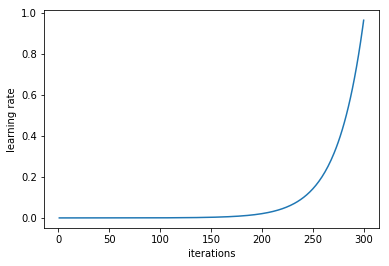

In [19]:
learn.sched.plot_lr()

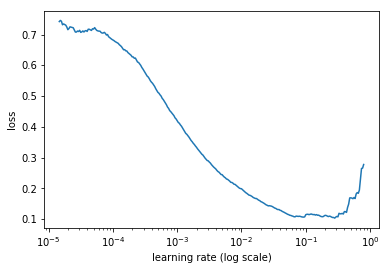

In [20]:
learn.sched.plot()

# Train last layer from precomputed activations for 1-2 epochs

In [21]:
learning_rate = 0.01

In [22]:
%time learn.fit(learning_rate, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.04972 0.03187 0.99072]                             
[1.      0.04703 0.02998 0.98975]                             
[2.      0.05535 0.02456 0.99121]                             



## Analyse output - TBD

# Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In [24]:
learn.precompute=False

In [25]:
%time learn.fit(learning_rate, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.05422 0.02919 0.98828]                             
[1.      0.03854 0.02657 0.99023]                             
[2.      0.0392  0.02458 0.98975]                             



In [26]:
learn.save(f'{project_name}_last_layer_{size}')

# Train full network with cycle_mult=2 until over-fitting

### Unfreeze all layers

In [27]:
learn.unfreeze()

### Find learning rate again

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [29]:
new_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 304/360 [01:16<00:14,  3.95it/s, loss=0.389] 

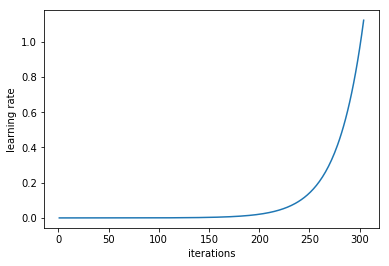

In [30]:
learn.sched.plot_lr()

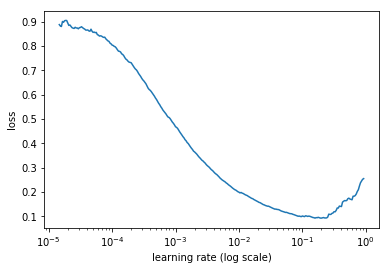

In [31]:
learn.sched.plot()

### Set earlier layers to 3x-10x lower learning rate than next higher layer

In [32]:
new_learning_rate = 0.01
#new_learning_rate = 0.005
#learning_rates = np.array([new_learning_rate/9, new_learning_rate/3, new_learning_rate])
learning_rates = np.array([1e-4, 1e-3, new_learning_rate])
#learning_rates = np.array([new_learning_rate/9, new_learning_rate/3, new_learning_rate])

### Train entire network

In [33]:
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  3%|▎         | 11/360 [00:03<01:38,  3.56it/s, loss=0.862]

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0.      0.05235 0.02926 0.98828]                             
[1.      0.04456 0.02565 0.99121]                             
[2.      0.04721 0.02536 0.99268]                             
[3.      0.04059 0.02599 0.99072]                             
[4.      0.03038 0.02542 0.99219]                             
[5.      0.03328 0.02559 0.99219]                             
[6.      0.03474 0.02555 0.99268]                             



In [34]:
learn.save(f'{project_name}_entire_network_{size}')

#### Validation set

In [35]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

0.9925

### Try with bigger image size

In [ ]:
data = get_data(299, 300, 340, bs)

In [ ]:
%time learn.fit(learning_rate, 3, cycle_len=1)

In [ ]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle-mult=2)

#### Validation set

In [35]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

0.9925

# Check accuracy

## Validation set

In [35]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

0.9925

## Test set

In [36]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.exp(test_log_preds)
accuracy(test_log_preds, test_y), metrics.log_loss(test_y, test_probs) # accuracy doesn't make sense here as test data has no lables

print(test_probs.shape)
print(test_probs[:4])

0.50112                                      
(12500, 2)
[[0.00705 0.99295]
 [0.99963 0.00037]
 [0.03025 0.96975]
 [0.00001 0.99999]]


# Submit to kaggle (optional)

In [37]:
isDog = test_probs[:,1]
print(isDog.shape)
print(len(isDog))
print(isDog[:5])


(12500,)
12500
[0.99295 0.00037 0.96975 0.99999 0.99915]


In [38]:
test_ds = learn.data.test_ds
print(test_ds)
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(test_filenames[:5])
print(test_dl.dataset.y.max())

['test1/9885.jpg', 'test1/2701.jpg', 'test1/11231.jpg', 'test1/2964.jpg', 'test1/10651.jpg']
0.0


In [39]:
fileIds = np.array([int(f[6:f.find('.')]) for f in test_filenames])
fileIds[:5]

array([ 9885,  2701, 11231,  2964, 10651])

In [40]:
submission = np.stack([fileIds,isDog], axis=1)
submission[:5]

array([[ 9885.     ,     0.99295],
       [ 2701.     ,     0.00037],
       [11231.     ,     0.96975],
       [ 2964.     ,     0.99999],
       [10651.     ,     0.99915]])

In [41]:
!pwd

/home/paperspace/fastai/courses/dl1


In [42]:
submission_file_name = 'submission1.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%d,%.10f', header='id,label', comments='')

In [43]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/submission1.csv

In [44]:
!date

Mon Jan 22 11:41:46 EST 2018
